In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv

import fnmatch
from scipy.io import wavfile
import scipy.io

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\demo data")
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.wav'):
        filename = os.path.join(data_dir, file)
filename 

'D:\\magistracy\\diplom\\demo data\\guitar.wav'

C:\Users\belas\AppData\Local\Temp/ipykernel_19332/3565526111.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , waveform = wavfile.read(filename)


(0.0, 1311195.0)

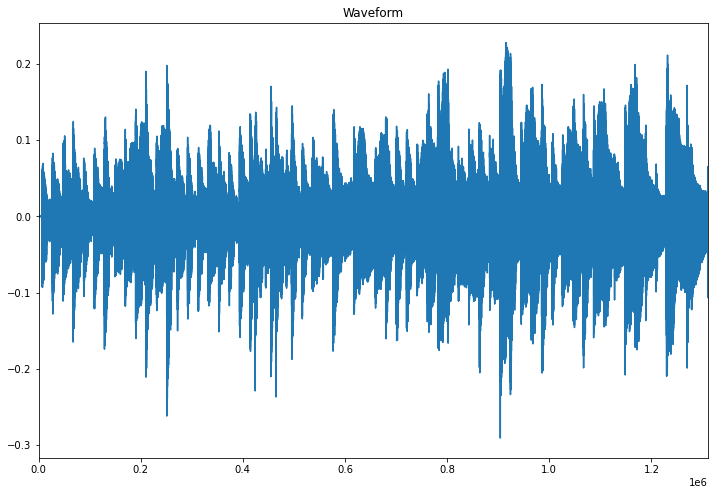

In [3]:
_ , waveform = wavfile.read(filename)
waveform = waveform[:,0]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(np.arange(waveform.shape[0]), waveform)
ax.set_title('Waveform')
ax.set_xlim([0, waveform.shape[0]])

In [4]:
model = load_model(r"D:\magistracy\diplom\model\model_3.h5")

In [5]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(1025, 40)


In [6]:
n = np.array(tf.io.gfile.listdir(str(pathlib.Path(r"D:\magistracy\diplom\records_cut"))))


notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    M = tf.convert_to_tensor(params[2])
    NFFT = 2048
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров
    
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
        
    return spectrogram

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [7]:
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.csv'):
        filename_csv = os.path.join(data_dir, file)
filename_csv   

'D:\\magistracy\\diplom\\demo data\\guitar.csv'

In [8]:
def freq_distrib(freq):
    note = None
    
    y = np.log(440/freq)/np.log(2**(1/12))
    z = round(y)%12
    if z < 0:
        z += 12 
       
    n = {0: 'A',
         1: 'G#',
         2: 'G',
         3: 'F#',
         4: 'F',
         5: 'E',
         6: 'D#',
         7: 'D',
         8: 'C#',
         9: 'C',
         10: 'B',
         11: 'A#'}
    note = n[z]

    return z, note

In [9]:
time_start = []
time_end = []
pitch = []
notes_real = []
with open(filename_csv) as f:
    reader = csv.reader(f)
    for row in reader:
        time_start.append(row[0])
        time_end.append(row[1])
        pitch.append(row[2][0:len(row[2])])  
    time_start = list(map(float,time_start[1:len(time_start)+1]))
    time_end = list(map(float,time_end[1:len(time_end)+1]))
    pitch = list(map(float,pitch[1:len(pitch)+1]))
    for i in range(len(pitch)):
        z, note = freq_distrib(440*2**((pitch[i]-69)/12))
        notes_real.append((time_start[i],time_end[i],note))
                           
notes_real[0:10]

[(0.146, 0.613, 'C'),
 (0.616, 1.072, 'D'),
 (1.075, 1.536, 'E'),
 (1.54, 1.982, 'D'),
 (1.985, 2.461, 'C'),
 (2.465, 2.916, 'B'),
 (2.92, 3.402, 'C'),
 (3.407, 3.85, 'G'),
 (3.85, 4.297, 'A'),
 (4.305, 4.772, 'A')]

In [10]:
L = len(notes_real)
wf_length = waveform.shape[0]
n = int(np.ceil(wf_length/L))

In [11]:
wf_notes = []
for k in range(0,wf_length,n):
    wf = waveform[k:k+n]
    spectrogram = get_spectrogram((wf,512,25))
    spectrogram = tf.expand_dims(spectrogram, 0)
    prediction = model(spectrogram)
    wf_notes.append((round(k/44100,3),round((k+n)/44100,3),notes[np.argmax(prediction[0])]))
wf_notes[0:10]

[(0.0, 0.465, 'A'),
 (0.465, 0.929, 'D'),
 (0.929, 1.394, 'E'),
 (1.394, 1.858, 'D'),
 (1.858, 2.323, 'A'),
 (2.323, 2.787, 'C'),
 (2.787, 3.252, 'C'),
 (3.252, 3.717, 'G#'),
 (3.717, 4.181, 'G#'),
 (4.181, 4.646, 'A')]

In [12]:
y_pred = [x[2] for x in wf_notes]
y_true = [x[2] for x in notes_real]
print(y_pred, '\n', y_true)

['A', 'D', 'E', 'D', 'A', 'C', 'C', 'G#', 'G#', 'A', 'D', 'A', 'C', 'D', 'A', 'C', 'E', 'D', 'C', 'C', 'D', 'C', 'D', 'C', 'C', 'C', 'G#', 'A', 'C', 'B', 'A', 'A', 'G#', 'B', 'C', 'C', 'A', 'G#', 'G#', 'G#', 'G#', 'G#', 'G#', 'G', 'A', 'A', 'A', 'G#', 'C#', 'C', 'A', 'G#', 'C', 'A', 'G#', 'G#', 'A', 'G#', 'G#', 'G#', 'G#', 'G#', 'G#', 'G#'] 
 ['C', 'D', 'E', 'D', 'C', 'B', 'C', 'G', 'A', 'A', 'D', 'A', 'C', 'D', 'C', 'B', 'E', 'D', 'C', 'B', 'D', 'C', 'B', 'A', 'D', 'C', 'B', 'A', 'C', 'B', 'G#', 'E', 'B', 'A', 'A', 'B', 'C#', 'B', 'A', 'G#', 'A', 'E', 'F#', 'F#', 'B', 'F#', 'A', 'B', 'A', 'G#', 'C#', 'B', 'A', 'G#', 'B', 'A', 'G#', 'F#', 'A', 'G#', 'F', 'C#', 'G#', 'F#']


In [13]:
notes = {0: 'A',
         1: 'G#',
         2: 'G',
         3: 'F#',
         4: 'F',
         5: 'E',
         6: 'D#',
         7: 'D',
         8: 'C#',
         9: 'C',
         10: 'B',
         11: 'A#'}

In [14]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
        
y_true = [get_key(notes,v) for v in y_true]
y_pred = [get_key(notes,v) for v in y_pred]
print(y_true, '\n', y_pred)

[9, 7, 5, 7, 9, 10, 9, 2, 0, 0, 7, 0, 9, 7, 9, 10, 5, 7, 9, 10, 7, 9, 10, 0, 7, 9, 10, 0, 9, 10, 1, 5, 10, 0, 0, 10, 8, 10, 0, 1, 0, 5, 3, 3, 10, 3, 0, 10, 0, 1, 8, 10, 0, 1, 10, 0, 1, 3, 0, 1, 4, 8, 1, 3] 
 [0, 7, 5, 7, 0, 9, 9, 1, 1, 0, 7, 0, 9, 7, 0, 9, 5, 7, 9, 9, 7, 9, 7, 9, 9, 9, 1, 0, 9, 10, 0, 0, 1, 10, 9, 9, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 8, 9, 0, 1, 9, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


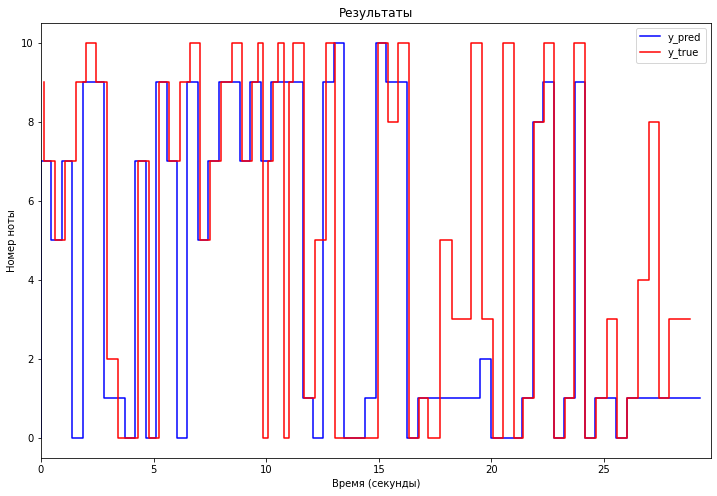

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 8))
timescale1 = [x[0] for x in wf_notes]
timescale2 = [x[0] for x in notes_real]
ax.step(timescale1, y_pred, color = 'blue')
ax.step(timescale2, y_true, color = 'red')
ax.set_title('Результаты')
ax.set_xlim([0, max(wf_notes[-1][1], notes_real[-1][1])])
ax.legend(['y_pred','y_true'])
plt.xlabel('Время (секунды)')
plt.ylabel('Номер ноты')
plt.show()

In [16]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_true, y_pred)
m.result().numpy()

0.34375

In [17]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

precision: 0.38802083333333337
recall: 0.34375


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn import metrics

print(metrics.classification_report(y_true, y_pred, labels = [0,1,2,3,4,5,6,7,8,9,10,11], digits=3))

              precision    recall  f1-score   support

           0      0.267     0.286     0.276        14
           1      0.143     0.429     0.214         7
           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         5
           4      0.000     0.000     0.000         1
           5      1.000     0.500     0.667         4
           6      0.000     0.000     0.000         0
           7      0.857     0.857     0.857         7
           8      0.000     0.000     0.000         3
           9      0.400     0.667     0.500         9
          10      0.500     0.077     0.133        13
          11      0.000     0.000     0.000         0

   micro avg      0.344     0.344     0.344        64
   macro avg      0.264     0.235     0.221        64
weighted avg      0.388     0.344     0.317        64



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Rec